In [20]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras
import tensorflow as tf

In [21]:
# Check if GPU is available and set the device accordingly
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    device_name = "GPU"
else:
    device_name = "CPU"
print(f"Using device: {device_name}")

Num GPUs Available:  1
Using device: GPU


In [22]:
# Data loading and preprocessing
def load_and_preprocess_images(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
    return images

In [23]:
def process_images_in_batches(folder, batch_size=32):
    processed_data = []
    for i in range(0, len(os.listdir(folder)), batch_size):
        batch_files = os.listdir(folder)[i:i+batch_size]
        batch_images = [cv2.imread(os.path.join(folder, file)) for file in batch_files if os.path.isfile(os.path.join(folder, file))]
        batch_preprocessed = [cv2.resize(img, (224, 224)) / 255.0 for img in batch_images if img is not None]
        processed_data.extend(batch_preprocessed)
        del batch_images
        del batch_preprocessed
    return np.array(processed_data)

In [24]:
# Paths to image directories
X_train_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_train'
Y_train_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/Y_train'
X_test_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_test'
Y_test_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/Y_test'

In [25]:
# Load and preprocess smaller-sized images directly
X_train_resized = load_and_preprocess_images(X_train_dir, target_size=(128, 128))
Y_train_resized = load_and_preprocess_images(Y_train_dir, target_size=(128, 128))
X_test_resized = load_and_preprocess_images(X_test_dir, target_size=(128, 128))
Y_test_resized = load_and_preprocess_images(Y_test_dir, target_size=(128, 128))

In [26]:
X_train_resized = np.array(X_train_resized)
Y_train_resized = np.array(Y_train_resized)
X_test_resized= np.array(X_test_resized)
Y_test_resized= np.array(Y_test_resized)

In [27]:
print('X_train_resized shape:', X_train_resized.shape)
print('Y_train_resized shape:', Y_train_resized.shape)
print('X_test_resized shape:', X_test_resized.shape)
print('Y_test_resized shape:', Y_test_resized.shape)

X_train_resized shape: (19287, 128, 128, 3)
Y_train_resized shape: (19287, 128, 128, 3)
X_test_resized shape: (3894, 128, 128, 3)
Y_test_resized shape: (3894, 128, 128, 3)


In [28]:
# Convert multi-channel label arrays to binary format
def convert_to_binary(labels):
    binary_labels = np.zeros((labels.shape[0], 1))
    for i in range(labels.shape[0]):
        if np.any(labels[i] > 0):  # Check if any value in the label array is above zero
            binary_labels[i] = 1    # Set as class 1 (cancerous feature) if any value is above zero
    return binary_labels

# Convert training and testing labels to binary format
Y_train_binary = convert_to_binary(Y_train_resized)
Y_test_binary = convert_to_binary(Y_test_resized)

In [30]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='valid'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='valid'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.25),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),
    Dropout(0.25),
    Dense(units=128, activation='relu'),
    Dropout(0.10),
    Dense(units=1, activation='sigmoid')  # Output layer for binary classification
])


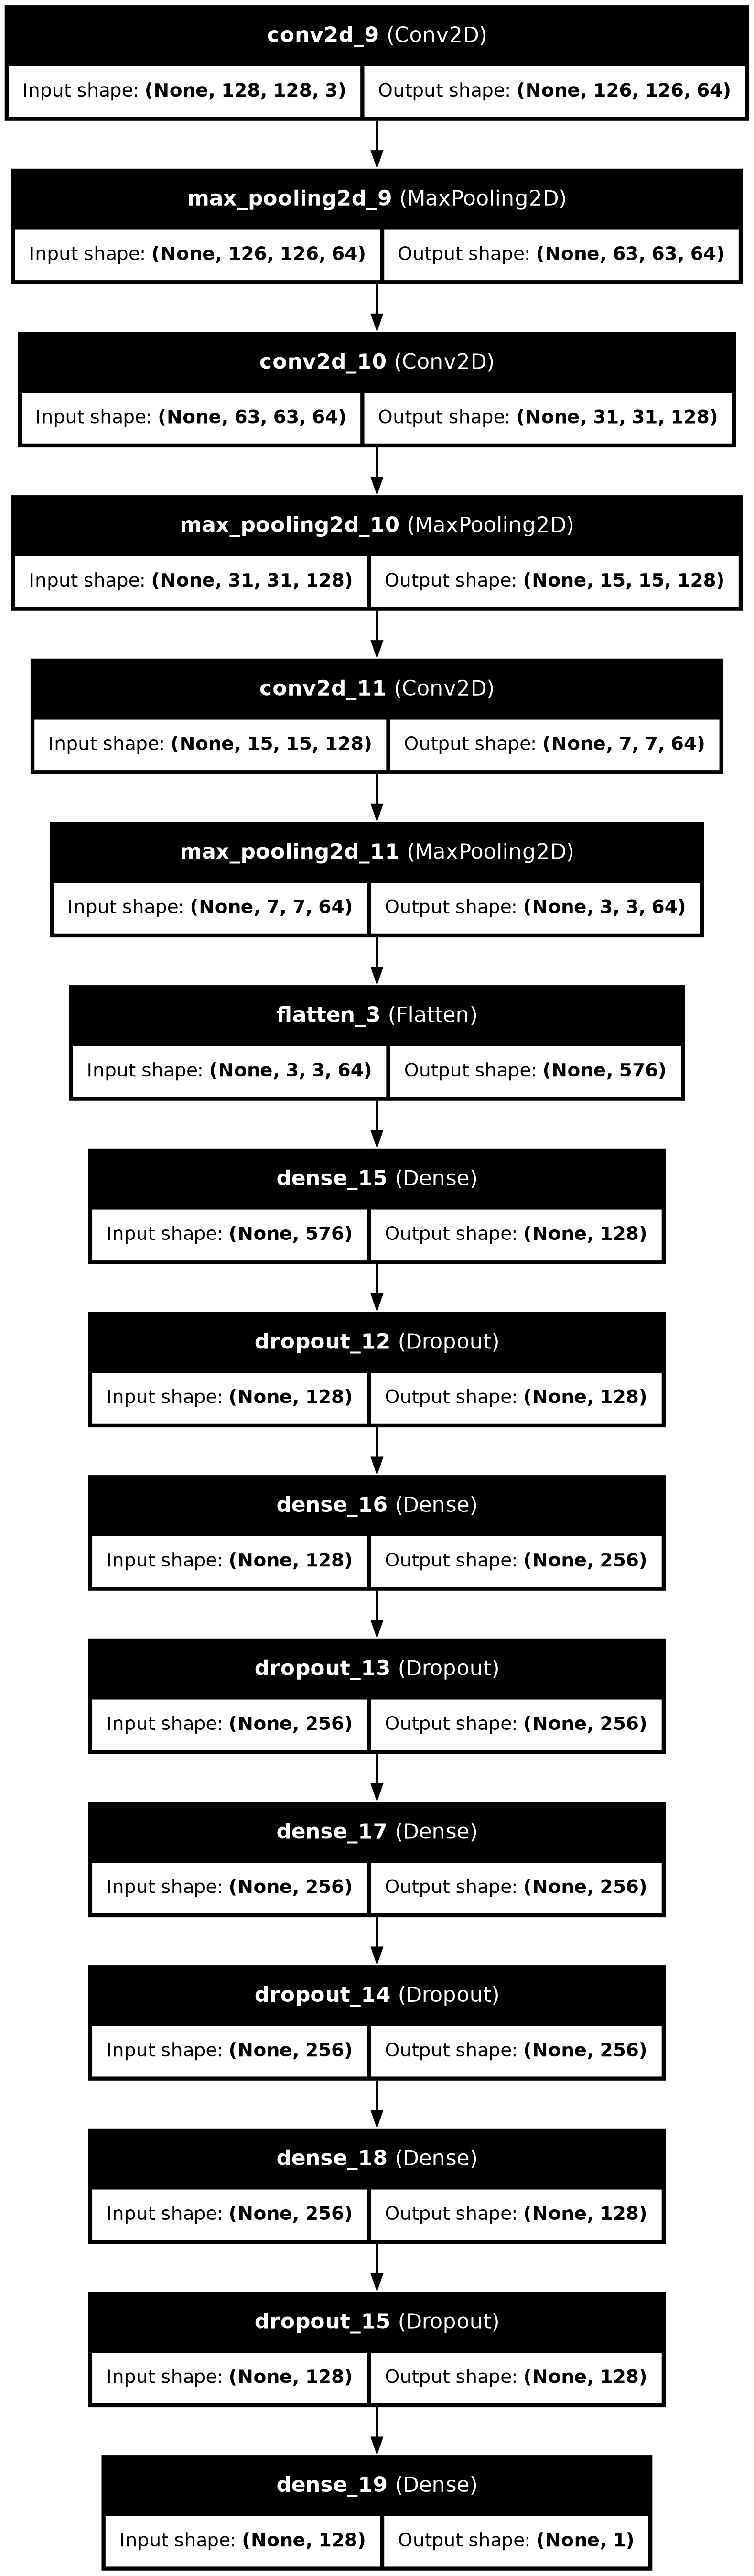

In [31]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

In [32]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,137 (1.35 MB)

 Trainable params: 355,137 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [49]:
# Apply data augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [50]:
# For test/validation data, only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
# Create data generators
train_generator = train_datagen.flow(X_train_resized, Y_train_binary, batch_size=32)
validation_generator = test_datagen.flow(X_test_resized, Y_test_binary, batch_size=32)

In [87]:
# Train the model with the augmented data
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=1,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=1,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6875 - loss: 0.6084 - val_accuracy: 0.7812 - val_loss: 0.5905 - learning_rate: 2.4414e-08
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7812 - loss: 0.5945 - val_accuracy: 0.9062 - val_loss: 0.5253 - learning_rate: 2.4414e-08
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7812 - loss: 0.5686 - val_accuracy: 0.7812 - val_loss: 0.5333 - learning_rate: 2.4414e-08
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7812 - loss: 0.5417 - val_accuracy: 0.8438 - val_loss: 0.5356 - learning_rate: 2.4414e-08
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6875 - loss: 0.5616 - val_accuracy: 0.7812 - val_loss: 0.5861 - learning_rate: 2.4414e-08
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7500 - loss: 0.5392 - val_accuracy: 0.9062 - val_loss: 0.5158 - learning_rate: 2.4414e-08
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6875 - loss: 0.5

In [88]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {accuracy:.2%}')

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8576 - loss: 0.5470
Test Accuracy: 85.98%


In [89]:
# Training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

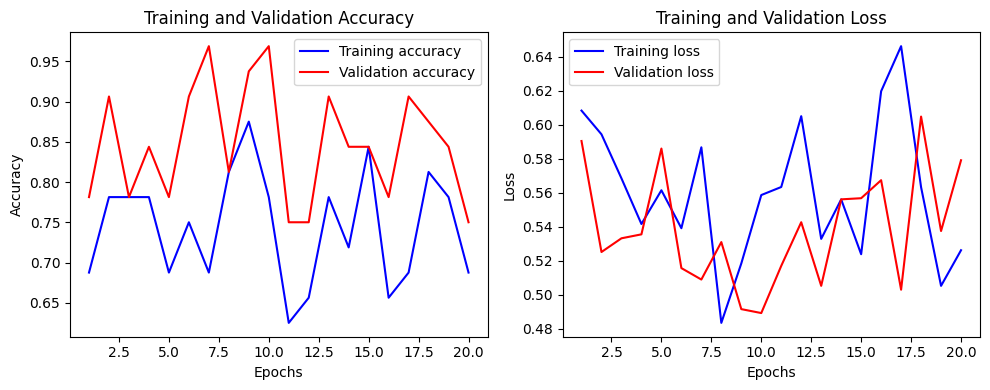

In [90]:
# Plotting accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/tmp/ipykernel_34/3384972359.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0]) if prediction > 0.5 else float(1 - prediction[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


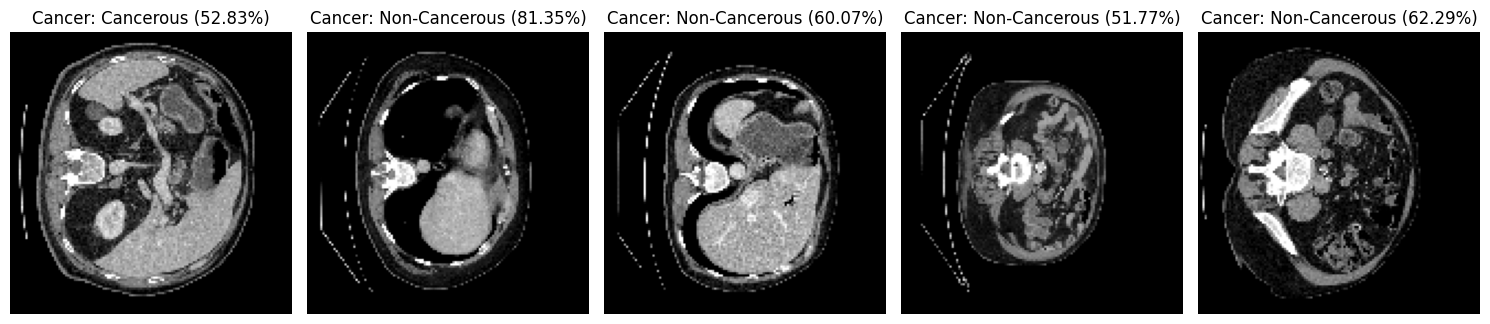

In [91]:
# Prediction functions
def load_and_transform_image(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0 
    return img, img_array

def predict_image(img_array):
    prediction = model.predict(img_array)
    class_label = 'Cancerous' if prediction > 0.5 else 'Non-Cancerous'
    confidence = float(prediction[0]) if prediction > 0.5 else float(1 - prediction[0])
    return class_label, confidence


def visualize_predictions(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    
    if len(image_paths) == 1:
        axes = [axes]
    
    for ax, image_path in zip(axes, image_paths):
        img, img_array = load_and_transform_image(image_path)
        class_label, confidence = predict_image(img_array)
        
        ax.imshow(img)
        ax.set_title(f'Cancer: {class_label} ({confidence:.2%})')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def get_random_test_images(test_dir, num_images=5):
    all_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png')]
    return random.sample(all_images, num_images)

# Directory containing test images
test_image_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_test'

# Get random test images
random_test_images = get_random_test_images(test_image_dir, num_images=5)

# Visualize predictions for random images
visualize_predictions(random_test_images)